### Alex Khvatov Homework #2

In [1]:
import pandas as pd
import numpy as np

Get laptops data

In [2]:
df_raw=pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv")

### Preparing the dataset

In [3]:
#Normalize the column names
df_raw.columns = df_raw.columns.str.lower().str.replace(' ', '_')

In [4]:
df_raw

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01
...,...,...,...,...,...,...,...,...,...,...,...,...
2155,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,Refurbished,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3060,17.3,No,2699.99
2156,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,Refurbished,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3070,17.3,No,2899.99
2157,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,Refurbished,Razer,Blade,Intel Core i7,32,1000,SSD,RTX 3080,17.3,No,3399.99
2158,Razer Book 13 Intel Evo Core i7-1165G7/16GB/1T...,Refurbished,Razer,Book,Intel Evo Core i7,16,1000,SSD,NaN,13.4,Yes,1899.99


In [5]:
#Let's create a copy our dataframe to limit to the columns we are interested in
df = df_raw[['ram','storage','screen','final_price']]


### Check for long tail

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: xlabel='final_price', ylabel='Count'>

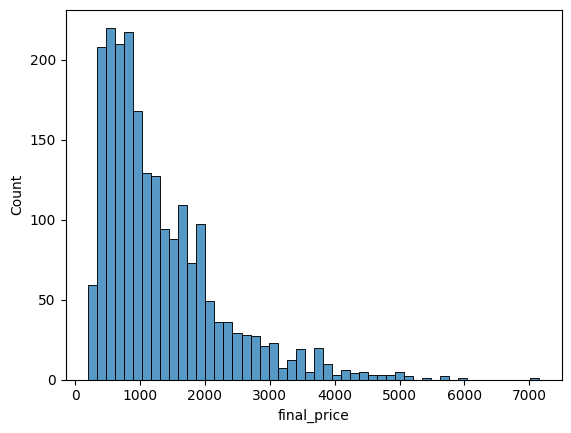

In [7]:
sns.histplot(df['final_price'], bins=50)

#### Conclusion: Yes, it does have a long tail distribution

### Question 1
There's one column with missing values. What is it?

In [8]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

__Answer__: 'screen'

### Question 2
What's the median (50% percentile) for variable 'ram'?

In [9]:
df['ram'].median()

np.float64(16.0)

__Answer__: 16

### Prepare the dataset

In [10]:
def prepare_dataset(df, seed):
    n=len(df)
    idx = np.arange(n)

    
    np.random.seed(seed)
    np.random.shuffle(idx)


    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    df_shuffled = df.iloc[idx]

    #Split the data into train, validation and test
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    
    df_train = df_train.reset_index()
    df_val = df_val.reset_index()
    df_test= df_test.reset_index()
    
    y_train = df_train.final_price.values #np.log1p(df_train.final_price.values)
    y_val = df_val.final_price.values #np.log1p(df_val.final_price.values)
    y_test = df_test.final_price.values #np.log1p(df_test.final_price.values)
        
    
    #Remove final_price
    del(df_train['final_price'])
    del(df_val['final_price'])
    del(df_test['final_price'])
    
    return (df_train, df_val, df_test, y_train, y_val, y_test)
    

### Quesiton 3
Question 3. Filling NAs

We have two options: fill it with 0 or with the mean of this variable.

Try both options. For each, train a linear regression model without regularization using the code from the lessons.

For computing the mean, use the training only!

Use the validation dataset to evaluate the models and compare the RMSE of each option.

In [11]:
df_train, df_val, df_test, y_train, y_val, y_test = prepare_dataset(df, 42)

In [12]:
len(df) == len(df_train) + len(df_val) + len(df_test)

True

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    1296 non-null   int64  
 1   ram      1296 non-null   int64  
 2   storage  1296 non-null   int64  
 3   screen   1293 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 40.6 KB


In [14]:
len(y_train)

1296

In [15]:
def prepare_X(df, fill_na_with=0):
    #No need to select columns - we did it above
    #fill_na_with - has a default value zero
    df_c = df.copy()
    df_c = df_c.fillna(fill_na_with)
    X = df_c.values
    return X

In [16]:
def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX=X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [17]:
#Prepare X train filled with zeroes
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0+ X_val.dot(w)


**Root mean squared error** 
$$RMSE=\sqrt{ 1/m\sum_{i=1}^m \left(g\left(x_i\right) - y_i\right)^2 }$$

In [18]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [19]:
print("When filled with Zeroes RMSE: ", round(rmse(y_val, y_pred),2))

When filled with Zeroes RMSE:  598.31


#### Fill with Mean

In [20]:
df_train, df_val, df_test, y_train, y_val, y_test = prepare_dataset(df, 42)

In [21]:
#We compute mean using only training data!
mean = df_train.screen.dropna().mean()
mean

np.float64(15.163534416086618)

In [22]:
X_train = prepare_X(df_train, mean)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, mean)
y_pred = w0+ X_val.dot(w)

In [23]:
print("When filled with Mean RMSE: ", round(rmse(y_val, y_pred),2))

When filled with Mean RMSE:  601.4


<Axes: ylabel='Count'>

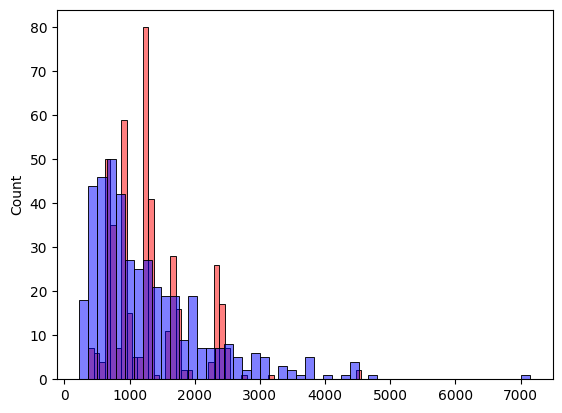

In [24]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which r gives the best RMSE?

In [25]:
def train_linear_regression_reg(X, y, r:float=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX=X.T.dot(X)
    XTX = XTX + r*np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]


In [26]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    X_val = prepare_X(df_val)
    y_pred = w0+ X_val.dot(w)
    
    score = round(rmse(y_val, y_pred),5)
    print(f"r value: {r} \tBias: {w0},\t RMSE: {score}")


r value: 0 	Bias: 723.4460087563663,	 RMSE: 598.30734
r value: 0.01 	Bias: 722.7411863658486,	 RMSE: 598.30433
r value: 0.1 	Bias: 716.4591021366367,	 RMSE: 598.27775
r value: 1 	Bias: 659.1688491443574,	 RMSE: 598.05729
r value: 5 	Bias: 486.3846142624667,	 RMSE: 597.63221
r value: 10 	Bias: 366.4182736284051,	 RMSE: 597.54904
r value: 100 	Bias: 67.80723488311286,	 RMSE: 598.08673


### Question 5

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))

In [27]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX=X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

def calculate_rmse_for(seed):
    df_train, df_val, df_test, y_train, y_val, y_test = prepare_dataset(df, seed)
    
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    
    X_val = prepare_X(df_val)
    y_pred = w0+ X_val.dot(w)
    
    return rmse(y_val, y_pred)

In [28]:
calculate_rmse_for(42)

np.float64(598.3073393148994)

In [29]:
rmse_for_seeds = {k:calculate_rmse_for(k) for k in seeds}
rmse_for_seeds

{0: np.float64(566.185865703133),
 1: np.float64(636.7597615661615),
 2: np.float64(588.972070825863),
 3: np.float64(597.5963177776609),
 4: np.float64(571.8763042773111),
 5: np.float64(573.6794781034947),
 6: np.float64(646.9343060563583),
 7: np.float64(550.3369862538037),
 8: np.float64(587.3918953179838),
 9: np.float64(576.5765862899498)}

In [30]:
print("Standard diviation of RMSE:",round(np.std(list(rmse_for_seeds.values())),3))

Standard diviation of RMSE: 28.996


In [31]:
#Not even close to any of the answers!

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with r=0.001.
* What's the RMSE on the test dataset?

In [32]:
seed = 9
df_train, df_val, df_test, y_train, y_val, y_test = prepare_dataset(df, seed)


#Combine training and validation datasets
df_full_train = pd.concat([df_train, df_val])
df_full_train.reset_index(inplace=True)

In [33]:
del(df_full_train['level_0'])

In [34]:
#print("Total combined records", len(df_full_train))
assert len(df)==len(df_full_train) + len(df_test)


X_full_train = prepare_X(df_full_train)

y_full_train = np.concat([y_train, y_val])


w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

X_test = prepare_X(df_test)

y_pred = w0+ X_test.dot(w)

score = rmse(y_test, y_pred)

#RMSE on the TEST dataset
print(f"RMSE with {score}")

Total combined records 1728
RMSE with 609.6609682768348
